# TensorFlow 教程 #01
# 简单线性模型

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

中文翻译 [thrillerist](https://zhuanlan.zhihu.com/insight-pixel)
/[Github](https://github.com/thrillerist/TensorFlow-Tutorials)

## 介绍

这份教程示范了在TensorFlow中使用一个简单线性模型的工作流程。在载入称为MNIST的手写数字图片数据集后，我们在TensorFlow中定义并优化了一个数学模型。（我们）会画出结果并展开讨论。  

你应该熟悉基本的线性代数，Python和Jupyter Notebook编辑器。如果你对机器学习和分类有基本的理解也很有帮助。

## 导入

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

使用Python3.6.2开发，TensorFlow版本是：

In [6]:
tf.__version__

'1.3.0'

## 载入数据

MNIST数据集大约有12MB，如果给定的地址里没有文件，它将自动下载。

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


现在已经载入了MNIST数据集，它由70,000张图像和对应的标签（比如图像的类别）组成。数据集分成三份互相独立的子集。我们在教程中只用训练集和测试集。

In [8]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


### One-Hot 编码

数据集以一种称为One-Hot编码的方式载入。这意味着标签从一个单独的数字转换成一个长度等于所有可能类别数量的向量。向量中除了第$i$个元素是1，其他元素都是0，这代表着它的类别是$i$'。比如，前面五张图像标签的One-Hot编码为：

In [9]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

在不同的比较和度量性能时，我们也需要用单独的数字表示类别，因此我们通过取最大元素的索引，将One-Hot编码的向量转换成一个单独的数字。需注意的是'class'在Python中是一个关键字，所以我们用'cls'代替它。

In [10]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

现在我们可以看到测试集中前面五张图像的类别。将这些与上面的One-Hot编码的向量进行比较。例如，第一张图像的类别是7，对应的在One-Hot编码向量中，除了第7个元素其他都为零。

In [11]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

### 数据维度

在下面的源码中，有很多地方用到了数据维度。在计算机编程中，通常来说最好使用变量和常量，而不是在每次使用数值时写硬代码。这意味着数字只需要在一个地方改动就行。这些最好能从读取的数据中获取，但这里我们直接写上数值。

In [12]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

### 用来绘制图像的帮助函数

这个函数用来在3x3的栅格中画9张图像，然后在每张图像下面写出真实的和预测的类别。

In [13]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

### 绘制几张图像来看看数据是否正确

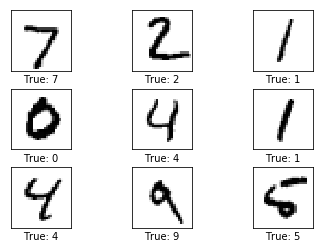

In [14]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow计算图

TensorFlow的全部目的就是使用一个称之为计算图（computational graph）的东西，它会比直接在Python中进行相同计算量要高效得多。TensorFlow比Numpy更高效，因为TensorFlow了解整个需要运行的计算图，然而Numpy只知道某个时间点上唯一的数学运算。

TensorFlow也能够自动地计算需要优化的变量的梯度，使得模型有更好的表现。这是由于Graph是简单数学表达式的结合，因此整个图的梯度可以用链式法则推导出来。

TensorFlow还能利用多核CPU和GPU，Google也为TensorFlow制造了称为TPUs（Tensor Processing Units）的特殊芯片，它比GPU更快。

一个TensorFlow图由下面几个部分组成，后面会详细描述：

* 占位符变量（Placeholder）用来改变图的输入。
* 模型变量（Model）将会被优化，使得模型表现得更好。
* 模型本质上就是一些数学函数，它根据Placeholder和模型的输入变量来计算一些输出。
* 一个cost度量用来指导变量的优化。
* 一个优化策略会更新模型的变量。

另外，TensorFlow图也包含了一些调试状态，比如用TensorBoard打印log数据，本教程不涉及这些。

### 占位符 （Placeholder）变量

Placeholder是作为图的输入，每次我们运行图的时候都可能会改变它们。将这个过程称为feeding placeholder变量，后面将会描述它。

首先我们为输入图像定义placeholder变量。这让我们可以改变输入到TensorFlow图中的图像。这也是一个张量（tensor），代表一个多维向量或矩阵。数据类型设置为`float32`，形状设为`[None, img_size_flat]`，`None`代表tensor可能保存着任意数量的图像，每张图象是一个长度为`img_size_flat`的向量。

In [15]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

接下来我们为输入变量`x`中的图像所对应的真实标签定义placeholder变量。变量的形状是`[None, num_classes]`，这代表着它保存了任意数量的标签，每个标签是长度为`num_classes`的向量，本例中长度为10。

In [16]:
y_true = tf.plsaceholder(tf.float32, [None, num_classes])

最后我们为变量`x`中图像的真实类别定义placeholder变量。它们是整形，并且这个变量的维度设为`[None]`，代表placeholder变量是任意长的一维向量。

In [17]:
y_true_cls = tf.placeholder(tf.int64, [None])

### 需要优化的变量

除了上面定义的那些给模型输入数据的变量之外，TensorFlow还需要改变一些模型变量，使得训练数据的表现更好。

第一个需要优化的变量称为权重`weight`，TensorFlow变量需要被初始化为零，它的形状是`[img_size_flat, num_classes]`，因此它是一个`img_size_flat`行、`num_classes`列的二维张量（或矩阵）。

需要使用`tf.Variable`来声明。

In [18]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

第二个需要优化的是偏差变量`biases`，它被定义成一个长度为`num_classes`的1维张量（或向量）。

In [19]:
biases = tf.Variable(tf.zeros([num_classes]))

### 模型

这个最基本的数学模型将placeholder变量`x`中的图像与权重`weight`相乘，然后加上偏差`biases`。

结果是大小为`[num_images, num_classes]`的一个矩阵，由于`x`的形状是`[num_images, img_size_flat]` 并且 `weights`的形状是`[img_size_flat, num_classes]`，因此两个矩阵乘积的形状是`[num_images, num_classes]`，然后将`biases`向量添加到矩阵每一行中。

In [20]:
logits = tf.matmul(x, weights) + biases

现在`logits`是一个 `num_images` 行`num_classes`列的矩阵，第$i$行第$j$列的那个元素代表着第$i$张输入图像有多大可能性是第$j$个类别。

然而，这是很粗略的估计并且很难解释，因为数值可能很小或很大，因此我们想要对它们做归一化，使得`logits`矩阵的每一行相加为1，每个元素限制在0到1之间。这是用一个称为softmax的函数来计算的，结果保存在`y_pred`中。

In [21]:
y_pred = tf.nn.softmax(logits)

可以从`y_pred`矩阵中取每行最大元素的索引值，来得到预测的类别。

In [23]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### 优化损失函数

为了使模型更好地对输入图像进行分类，我们必须改变`weights`和`biases`变量。首先我们需要比较模型的预测输出`y_pred`和期望输出`y_true`，来了解目前模型的性能如何。

交叉熵（cross-entropy）是一个在分类中使用的性能度量。交叉熵是一个常为正值的连续函数，如果模型的预测值精准地符合期望的输出，它就等于零。因此，优化的目的就是最小化交叉熵，通过改变模型中`weights`和`biases`的值，使交叉熵越接近零越好。

TensorFlow有一个内置的计算交叉熵的函数。需要注意的是它使用`logits`的值，因为在它内部也计算了softmax。


In [24]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

现在，我们已经为每个图像分类计算了交叉熵，所以有一个当前模型在每张图上的性能度量。但是为了用交叉熵来指导模型变量的优化，我们需要一个额外的标量值，因此我们简单地利用所有图像分类交叉熵的均值。

In [25]:
cost = tf.reduce_mean(cross_entropy)

### 优化方法

现在，我们有一个需要被最小化的损失度量，接着我们可以创建优化器。在这种情况中，用的是梯度下降的基本形式，步长设为0.5。

优化过程并不是在这里执行。实际上，还没计算任何东西，我们只是往TensorFlow图中添加了优化器，以便之后的操作。

In [26]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### 性能度量

我们需要另外一些性能度量，来向用户展示这个过程。

这是一个布尔值向量，代表预测类型是否等于每张图片的真实类型。

In [27]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

上面先将布尔值向量类型转换成浮点型向量，这样子False就变成0，True变成1，然后计算这些值的平均数，以此来计算分类的准确度。

In [28]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## 运行TensorFlow

### 创建TensorFlow会话（session）

一旦创建了TensorFlow图，我们需要创建一个TensorFlow session，用来运行图。

In [29]:
session = tf.Session()

### 初始化变量

我们需要在开始优化`weights`和`biases`变量之前对它们进行初始化。

In [30]:
session.run(tf.global_variables_initializer())

### 用来优化迭代的帮助函数

在训练集中有50,000张图。用这些图像计算模型的梯度会花很多时间。因此我们利用随机梯度下降的方法，它在优化器的每次迭代里只用到了一小部分的图像。

In [32]:
batch_size = 128

函数执行了多次的优化迭代来逐步地提升模型的`weights`和`biases`。在每次迭代中，从训练集中选择一批新的数据，然后TensorFlow用这些训练样本来执行优化器。

In [33]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

### 展示性能的帮助函数

测试集数据字典被当做TensorFlow图的输入。注意，在TensorFlow图中，placeholder变量必须使用正确的名字。

In [34]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

用来打印测试集分类准确度的函数。

In [35]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

用scikit-learn打印混淆矩阵。

In [36]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

绘制测试集中误分类图像的函数。

In [37]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### 绘制模型权重的帮助函数

这个函数用来绘制模型的权重`weights`。画了10张图像，训练模型所识别出的每个数字对应着一张图。

In [38]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

## 优化之前的性能

测试集上的准确度是9.8%。这是由于模型只做了初始化，并没做任何优化，所以它通常将图像预测成数字零，正如下面绘制的图像那样，刚好测试集中9.8%的图像是数字零。

In [39]:
print_accuracy()

Accuracy on test-set: 9.8%


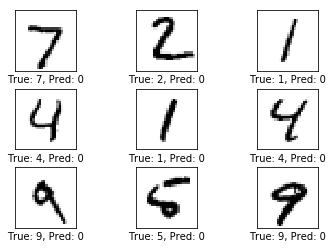

In [40]:
plot_example_errors()

## 1次迭代优化后的性能

在完成一次迭代优化之后，模型在测试集上的准确率从9.8%提高到了30.9%。这意味着它大约10次里面会误分类7次，正如下面所显示的。

In [41]:
optimize(num_iterations=1)

In [42]:
print_accuracy()

Accuracy on test-set: 30.9%


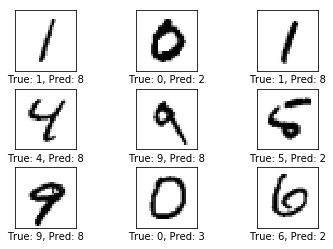

In [43]:
plot_example_errors()

下面绘制的是权重。正值为红色，负值为蓝色。这些权重可以直观地理解为图像滤波器。

例如，权重用来确定一张数字零的图像对圆形图像有正反应（红色），对圆形图像的中间部分有负反应（蓝色）。

类似的，权重也用来确定一张数字一的图像对图像中心垂直线段有正反应（红色），对线段周围有负反应（蓝色）。

注意到权重大多看起来跟它要识别的数字很像。这是因为只做了一次迭代，即权重只在100张图像上训练。等经过上千张图像的训练之后，权重会变得更难分辨，因为它们需要识别出数字的许多种书写方法。

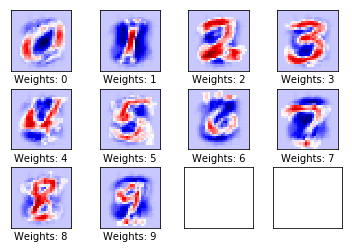

In [44]:
plot_weights()

## 10次优化迭代后的性能

In [45]:
# We have already performed 1 iteration.
optimize(num_iterations=9)

In [46]:
print_accuracy()

Accuracy on test-set: 77.1%


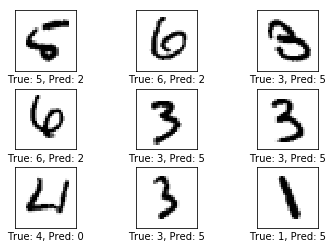

In [47]:
plot_example_errors()

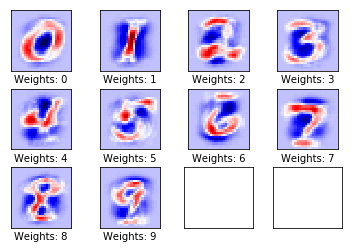

In [48]:
plot_weights()

## 1000次迭代之后的性能

在迭代了1000次之后，模型在十次里面大约只误识别了一次。如下图所示，有些误识别情有可原，因为即使在人类眼里，也很难确定图像（的数字），然而有一些图像是很明显的，好的模型应该能分辨出来。但这个简单的模型无法达到更好的性能，因此需要更为复杂的模型。

In [49]:
# We have already performed 10 iterations.
optimize(num_iterations=990)

In [50]:
print_accuracy()

Accuracy on test-set: 91.9%


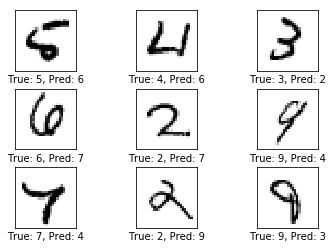

In [51]:
plot_example_errors()

模型经过了1000次迭代训练，每次迭代用到训练集里面的100张图像。由于图像的多样化，现在权重变得很难辨认，我们可能会怀疑这些权重是否真的理解数字是怎么由线条组成的，或者模型只是记住了许多不同的像素。

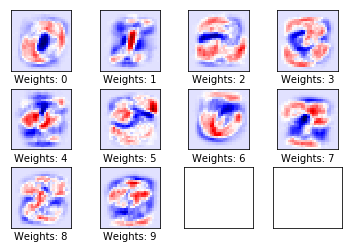

In [52]:
plot_weights()

我们也可以打印并绘制出混淆矩阵，它让我们看到误分类的更多细节。例如，它展示了描绘着数字5的图像有时会被误分类成其他可能的数字，但大多是3，6或8。

[[ 949    0    5    3    0    8    9    4    2    0]
 [   0 1112    2    2    0    2    4    2   11    0]
 [   4    8  937   11    8    4   13   10   29    8]
 [   3    1   29  898    0   38    2   17   13    9]
 [   1    2    6    1  911    0   13    2    6   40]
 [   8    4    9   31    8  778   15    8   24    7]
 [   7    3    5    1    9   15  914    2    2    0]
 [   2    7   29    6    6    1    0  949    2   26]
 [   6   11    9   25    9   37   10   15  845    7]
 [   8    6    3   11   36   15    0   31    5  894]]


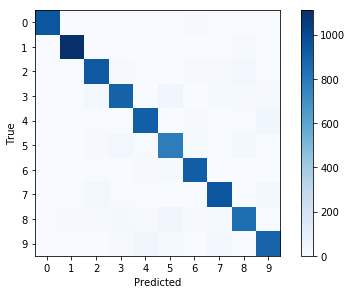

In [53]:
print_confusion_matrix()

现在我们用TensorFlow完成了任务，关闭session，释放资源。

In [54]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
session.close()

## 练习

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

下面使一些可能会让你提升TensorFlow技能的一些建议练习。为了学习如何更合适地使用TensorFlow，实践经验是很重要的。
在你对这个Notebook进行修改之前，可能需要先备份一下。

* 改变优化器的学习率。
* 改变优化器，比如用`AdagradOptimizer` 或 `AdamOptimizer`。
* 将batch-size改为1或1000。
* 这些改变如何影响性能？
* 你觉得这些改变对其他分类问题或数学模型有相同的影响吗?
* 如果你不改变任何参数，多次运行Notebook，会得到完成一样的结果吗？为什么？
* 改变`plot_example_errors()` 函数，使它打印误分类的 `logits`和`y_pred`值。
* 用`sparse_softmax_cross_entropy_with_logits` 代替 `softmax_cross_entropy_with_logits`。这可能需要改变代码的多个地方。探讨使用这两中方法的优缺点。
* 不看源码，自己重写程序。
* 向朋友解释程序如何工作。

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.